# Deep Dream

In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)













87916544/87910968 [==============================] - 49s 1us/step


In [3]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
    "mixed2": 0.2,
    "mixed3": 3.0,
    "mixed4": 2.0,
    "mixed5": 1.5,
}

In [4]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.0)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), "float32"))
    loss += coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

In [5]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print("...Loss value at", i, ":", loss_value)
        x += step * grad_values
    return x

In [6]:
import scipy
from keras.preprocessing import image


def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == "channels_first":
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.0
    x += 0.5
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [8]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.0

# Fill this to the path to the image you want to use
base_image_path = "./data/original_photo_deep_dream.jpg"

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print("Processing image shape", shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname="dream_at_scale_" + str(shape) + ".png")

save_img(img, fname="final_dream.png")

Processing image shape (870, 1306)
...Loss value at 0 : 1.5622786
...Loss value at 1 : 2.1039417
...Loss value at 2 : 2.8753035
...Loss value at 3 : 3.7869258
...Loss value at 4 : 4.675101
...Loss value at 5 : 5.5269485
...Loss value at 6 : 6.358029
...Loss value at 7 : 7.153227
...Loss value at 8 : 7.9094872
...Loss value at 9 : 8.666781
...Loss value at 10 : 9.371813


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Processing image shape (1218, 1828)
...Loss value at 0 : 3.4101586
...Loss value at 1 : 4.846016
...Loss value at 2 : 6.023861
...Loss value at 3 : 7.057817
...Loss value at 4 : 8.039001
...Loss value at 5 : 8.957248
...Loss value at 6 : 9.824572
Processing image shape (1706, 2560)
...Loss value at 0 : 3.3964956
...Loss value at 1 : 4.7954435
...Loss value at 2 : 5.985641
...Loss value at 3 : 7.069662
...Loss value at 4 : 8.100237
...Loss value at 5 : 9.069395
...Loss value at 6 : 9.984702


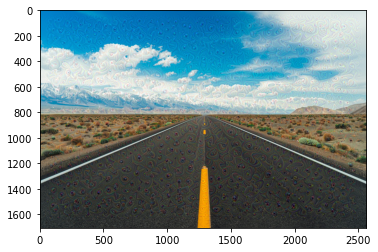

In [9]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()